In [4]:

!pip install -q torch torchvision torcheval

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torcheval.metrics import MulticlassAccuracy, MulticlassConfusionMatrix
import os
from google.colab import drive


drive.mount('/content/drive')
MODEL_SAVE_PATH = '/content/drive/MyDrive/XAI_ViT_Lung/models/resnet/resnet50_pneumonia.pth'
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 7.6 MB/s eta 0:00:00
Mounted at /content/drive


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [5]:


import os
import json


!mkdir -p ~/.kaggle
api_token = {
    "username": "akSuyek",
    "key": "KGAT_332e002490b1463cac3728d361a67006"
}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list -m

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -qo chest-xray-pneumonia.zip
!unzip -qo chest_xray/chest_xray.zip -d chest_xray

print("Датасет успешно скачан и распакован!")

No datasets found
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:15<00:00, 126MB/s]
100% 2.29G/2.29G [00:15<00:00, 157MB/s]
unzip:  cannot find or open chest_xray/chest_xray.zip, chest_xray/chest_xray.zip.zip or chest_xray/chest_xray.zip.ZIP.
Датасет успешно скачан и распакован!


In [6]:
#70/15/15 сплит
import shutil
from pathlib import Path
import random

random.seed(42)  #

raw_dir = Path('chest_xray/chest_xray')
data_dir = Path('lung_data')
data_dir.mkdir(exist_ok=True)

for split in ['train', 'val', 'test']:
    for cls in ['normal', 'pneumonia']:
        os.makedirs(data_dir / split / cls, exist_ok=True)


normal_paths = list((raw_dir / 'train' / 'NORMAL').glob('*.jpeg')) + \
               list((raw_dir / 'test' / 'NORMAL').glob('*.jpeg'))
pneumonia_paths = list((raw_dir / 'train' / 'PNEUMONIA').glob('*.jpeg')) + \
                  list((raw_dir / 'test' / 'PNEUMONIA').glob('*.jpeg'))

random.shuffle(normal_paths)
random.shuffle(pneumonia_paths)

normal_paths = normal_paths[:670]
pneumonia_paths = pneumonia_paths[:670]
train_per_class = 469
val_per_class = 101
test_per_class = 100

def copy_split(paths, cls_name):
    for i, p in enumerate(paths):
        if i < train_per_class:
            split = 'train'
        elif i < train_per_class + val_per_class:
            split = 'val'
        else:
            split = 'test'
        shutil.copy(p, data_dir / split / cls_name / p.name)

copy_split(normal_paths, 'normal')
copy_split(pneumonia_paths, 'pneumonia')


print(f"Распределение на класс: train {train_per_class}, val {val_per_class}, test {test_per_class}")
print(f"Общее: train {train_per_class*2}, val {val_per_class*2}, test {test_per_class*2}")
print(f"Путь: {data_dir}")

Распределение на класс: train 469, val 101, test 100
Общее: train 938, val 202, test 200
Путь: lung_data


In [7]:
#Data Augmentation & Preprocessing
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'lung_data'

image_datasets = {x: datasets.ImageFolder(data_dir + '/' + x, data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=False if x == 'test' else True, num_workers=2)
               for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes  # ['normal', 'pneumonia']

print(f"Classes: {class_names}")
print(f"Sizes: train {dataset_sizes['train']}, val {dataset_sizes['val']}, test {dataset_sizes['test']}")

Classes: ['normal', 'pneumonia']
Sizes: train 938, val 202, test 200


In [8]:
#ResNet50 + fine-tuning
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

model = models.resnet50(pretrained=True)

#Freezing Layers except [-1]
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  #2 classes

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


MODEL_SAVE_PATH = '/content/drive/MyDrive/XAI_ViT_Lung/models/resnet/resnet50_best.pth'
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

Using cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 129MB/s]


In [9]:
#Training ResNet50
num_epochs = 20
best_acc = 0.0
best_model_state = None

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_state = model.state_dict()
            torch.save(best_model_state, MODEL_SAVE_PATH)
            print(f"Val Acc: {best_acc:.4f}")

print(f'\nBest Val Accuracy: {best_acc:.4f}')

Epoch 1/20
----------
Train Loss: 0.6490 Acc: 0.6194
Val Loss: 0.4815 Acc: 0.7574
Val Acc: 0.7574
Epoch 2/20
----------
Train Loss: 0.4600 Acc: 0.8028
Val Loss: 0.5009 Acc: 0.7723
Val Acc: 0.7723
Epoch 3/20
----------
Train Loss: 0.4117 Acc: 0.8209
Val Loss: 0.3367 Acc: 0.8663
Val Acc: 0.8663
Epoch 4/20
----------
Train Loss: 0.3918 Acc: 0.8390
Val Loss: 0.3653 Acc: 0.8416
Epoch 5/20
----------
Train Loss: 0.4213 Acc: 0.8134
Val Loss: 0.3361 Acc: 0.8762
Val Acc: 0.8762
Epoch 6/20
----------
Train Loss: 0.3912 Acc: 0.8326
Val Loss: 0.3321 Acc: 0.8812
Val Acc: 0.8812
Epoch 7/20
----------
Train Loss: 0.3447 Acc: 0.8625
Val Loss: 0.3348 Acc: 0.8812
Epoch 8/20
----------
Train Loss: 0.3485 Acc: 0.8486
Val Loss: 0.3642 Acc: 0.8663
Epoch 9/20
----------
Train Loss: 0.3682 Acc: 0.8433
Val Loss: 0.3658 Acc: 0.8663
Epoch 10/20
----------
Train Loss: 0.3326 Acc: 0.8753
Val Loss: 0.3314 Acc: 0.8812
Epoch 11/20
----------
Train Loss: 0.3375 Acc: 0.8657
Val Loss: 0.3462 Acc: 0.8812
Epoch 12/20
----

              precision    recall  f1-score   support

      normal       0.84      0.96      0.90       100
   pneumonia       0.95      0.82      0.88       100

    accuracy                           0.89       200
   macro avg       0.90      0.89      0.89       200
weighted avg       0.90      0.89      0.89       200



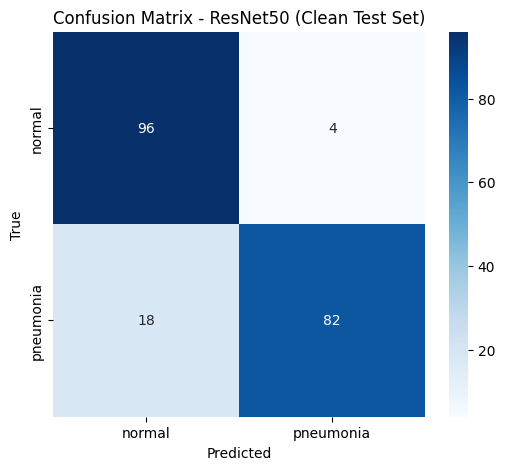


Собрано примеров для анализа:
TP: 10 примеров
TN: 10 примеров
FP: 4 примеров
FN: 10 примеров


In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

examples = {
    'TP': [],   # (image_tensor, pred, true, prob)
    'TN': [],
    'FP': [],
    'FN': []
}

all_preds = []
all_labels = []
all_probs = []
all_images = []  # denormalized

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)


        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:,1].cpu().numpy())  # probability
        #saving images
        for i in range(inputs.size(0)):
            img = inv_normalize(inputs[i].cpu())
            img = torch.clamp(img, 0, 1)

            true_label = labels[i].item()
            pred_label = preds[i].item()
            prob_pneumonia = probs[i,1].item()

            category = ''
            if pred_label == 1 and true_label == 1:
                category = 'TP'
            elif pred_label == 0 and true_label == 0:
                category = 'TN'
            elif pred_label == 1 and true_label == 0:
                category = 'FP'
            elif pred_label == 0 and true_label == 1:
                category = 'FN'

            if len(examples[category]) < 10:  #10 ex each
                examples[category].append({
                    'image': img,
                    'pred': pred_label,
                    'true': true_label,
                    'prob': prob_pneumonia,
                    'filename': image_datasets['test'].imgs[len(all_images)][0]  #path
                })

            all_images.append(img)

print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet50 (Clean Test Set)')
plt.show()

print("\nСобрано примеров для анализа:")
for k, v in examples.items():
    print(f"{k}: {len(v)} примеров")

In [13]:
# Блок 8: Добавление шума и анализ стабильности Grad-CAM (ИСПРАВЛЕННЫЙ)
!pip install -q grad-cam

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import random

# Нормализация (та же, как в data_transforms)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Типы шума (на [0,1] диапазоне)
noise_types = {
    'clean': None,
    'gaussian_low': lambda x: x + torch.randn_like(x) * 0.05,
    'gaussian_medium': lambda x: x + torch.randn_like(x) * 0.15,
    'blur_light': transforms.GaussianBlur(kernel_size=3, sigma=1.0),
    'blur_medium': transforms.GaussianBlur(kernel_size=5, sigma=2.0),
    'contrast_low': lambda x: TF.adjust_contrast(x, 0.5),
    'contrast_high': lambda x: TF.adjust_contrast(x, 1.8),
}

# Папка для результатов
results_dir = '/content/drive/MyDrive/XAI_ViT_Lung/explainability/resnet_gradcam/'
os.makedirs(results_dir, exist_ok=True)

cam = GradCAM(model=model, target_layers=[model.layer4[-1]])

# Функция визуализации (с нормализацией перед моделью)
def visualize_example(example_dict, noise_name, noise_func):
    img_tensor = example_dict['image'].unsqueeze(0).to(device)  # денорм [0,1], (1,3,224,224)

    if noise_func is not None:
        if 'gaussian' in noise_name:
            noisy_input = noise_func(img_tensor)
        else:
            noisy_input = noise_func(img_tensor)
        noisy_input = torch.clamp(noisy_input, 0, 1)
    else:
        noisy_input = img_tensor

    # ВИЗУАЛИЗАЦИЯ использует noisy_input (денорм)
    rgb_img = noisy_input[0].cpu().permute(1,2,0).numpy()  # для show_cam

    # МОДЕЛЬ получает нормализованный input
    model_input = normalize(noisy_input[0]).unsqueeze(0)  # нормализуем и добавляем batch dim

    # Предсказание
    model.eval()
    with torch.no_grad():
        output = model(model_input)
        prob = torch.softmax(output, dim=1)[0,1].item()  # P(pneumonia)
        pred = output.argmax(dim=1).item()

    # Grad-CAM (на нормализованном input)
    targets = [ClassifierOutputTarget(pred)]  # target = предсказанный класс (лучше для explainability)
    grayscale_cam = cam(input_tensor=model_input, targets=targets)[0]

    # Наложение
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Сохранение (с оригинальной category)
    category = 'TP' if example_dict['true'] == 1 and example_dict['pred'] == 1 else \
               'TN' if example_dict['true'] == 0 and example_dict['pred'] == 0 else \
               'FP' if example_dict['true'] == 0 and example_dict['pred'] == 1 else 'FN'

    filename = f"{category}_{noise_name}_{os.path.basename(example_dict['filename'])}.png"
    plt.imsave(results_dir + filename, visualization)

    change = "→ ошибка" if pred != example_dict['true'] else ""
    return pred, prob, change

# Обработка (по 5 примеров)
for category in ['TP', 'TN', 'FP', 'FN']:
    if len(examples[category]) == 0:
        print(f"\nНет примеров для {category} — проверьте test report на imbalance ошибок.")
        continue
    selected = random.sample(examples[category], min(5, len(examples[category])))
    print(f"\nОбрабатываем {category} ({len(selected)} примеров)")

    for idx, ex in enumerate(selected):
        print(f"  Пример {idx+1}: original clean prob (P(pneumonia)) = {ex['prob']:.3f}")
        for noise_name, noise_func in noise_types.items():
            pred, prob, change = visualize_example(ex, noise_name, noise_func)
            print(f"    {noise_name:15} → prob: {prob:.3f}, pred: {class_names[pred]} {change}")


Обрабатываем TP (5 примеров)
  Пример 1: original clean prob (P(pneumonia)) = 0.865
    clean           → prob: 0.865, pred: pneumonia 
    gaussian_low    → prob: 0.767, pred: pneumonia 
    gaussian_medium → prob: 0.995, pred: pneumonia 
    blur_light      → prob: 0.845, pred: pneumonia 
    blur_medium     → prob: 0.940, pred: pneumonia 
    contrast_low    → prob: 0.990, pred: pneumonia 
    contrast_high   → prob: 0.115, pred: normal → ошибка
  Пример 2: original clean prob (P(pneumonia)) = 0.995
    clean           → prob: 0.995, pred: pneumonia 
    gaussian_low    → prob: 0.650, pred: pneumonia 
    gaussian_medium → prob: 0.997, pred: pneumonia 
    blur_light      → prob: 0.985, pred: pneumonia 
    blur_medium     → prob: 0.990, pred: pneumonia 
    contrast_low    → prob: 0.995, pred: pneumonia 
    contrast_high   → prob: 0.907, pred: pneumonia 
  Пример 3: original clean prob (P(pneumonia)) = 0.901
    clean           → prob: 0.901, pred: pneumonia 
    gaussian_low    